In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from chembl_webresource_client.new_client import new_client
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('preprocessed_bioactivity_data.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,Intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,Intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,Inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,Inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,Intermediate
...,...,...,...,...
100,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,Inactive
101,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,Inactive
102,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,Inactive
103,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,Inactive


### Next we clean the canonical smiles

In [3]:
df_no_smiles = df.drop(columns= 'canonical_smiles')

In [4]:
smiles = []

for i in df.canonical_smiles.tolist():
    
    cpd = str(i).split('.')
    
    cpd_longest = max(cpd, key=len)
    
    smiles.append(cpd_longest)
    
smiles = pd.Series(smiles, name='canonical_smiles')

In [5]:
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles
0,CHEMBL187579,7200.0,Intermediate,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21
1,CHEMBL188487,9400.0,Intermediate,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21
2,CHEMBL185698,13500.0,Inactive,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21
3,CHEMBL426082,13110.0,Inactive,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21
4,CHEMBL187717,2000.0,Intermediate,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-]
...,...,...,...,...
100,CHEMBL2146517,10600.0,Inactive,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...
101,CHEMBL187460,10100.0,Inactive,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C
102,CHEMBL363535,11500.0,Inactive,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12
103,CHEMBL227075,10700.0,Inactive,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1


In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### CALCULATE THE LIPINSKY DESCRIPTORS

<br>

#### About Lipinsky's rule of 5;

<br>

Lipinski's rule of five was formulated by Christopher A. Lipinski in 1997 based on the oservation that most orally administered<br> drugs are relatively small and moderately lipophilic molecules. The Lipinski's rule of 5 also known as the <br> Pfizer's rule of 5 is a rule of thumb to evaluate druglikeness  or determine if a chemical compound with a pharmacological or <br> biological activity has the chemical properties and physical properties that would make it a likely orally active drug<br> in humans
<br>

The rule describes molecular properties important for a drug's pharmacokenitics in the human body, including their absorption,<br> distribution, metabolism and excretion.("ADME"). However, the rule does not predict if the compound is pharmaco-<br>logically active.

<br>

#### Components of the rule:

<br>

The lipinski's rule states that, in general, an orally active drug has no more than violation of the following criteria:

<ol> 1. No more than 5 hydrogen bond donors (the total number of nitrogen-hydrogen and oxygen-hydrogen bonds).
    <br>
    2. No more than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms).
    <br>
    3. A molecular mass less than 500 daltons.
    <br>
    4. A calculated octanol-water partition coefficient (Clog P) that does not exceed 5.
</ol>

you can read more on this here; __[Link to wikipedia lipinski's rule of 5](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five)__

### CALCULATE DESCRIPTORS

In [7]:
def lipinski(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)
        
    base_data = np.arange(1,1)
    i = 0
    for mol in moldata:
        
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        
        row = np.array([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])
        
        if(i==0):
            base_data = row
        else:
            base_data = np.vstack([base_data, row])
        i = i + 1
        
    
    col_Names = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
    descriptors = pd.DataFrame(data=base_data, columns=col_Names)
    
    return descriptors

In [8]:
Lipinski_df = lipinski(df.canonical_smiles)

In [9]:
Lipinski_df

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
100,338.359,3.40102,0.0,5.0
101,296.366,3.44330,0.0,3.0
102,276.291,4.09564,0.0,3.0
103,278.307,3.29102,0.0,3.0


### COMBINE DATAFRAMES (df and Lipinski_df)


In [10]:
new_df = pd.concat([df, Lipinski_df], axis=1)
new_df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,Intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,Intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,Inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,Inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,Intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
100,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,Inactive,338.359,3.40102,0.0,5.0
101,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,Inactive,296.366,3.44330,0.0,3.0
102,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,Inactive,276.291,4.09564,0.0,3.0
103,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,Inactive,278.307,3.29102,0.0,3.0


### Convert IC50 to pIC50
<br>

To allow IC50 data to be more uniformly distributed , we will convert the IC50 to the negative logarithmic scale which<br> is essentially $-log10(IC50)$.
<br>

This custom function pIC50() will accept a DataFrame as input and do the following;

<ol>
 1. Take the IC50 values from the standard_value column and convert it from $nM$ to $M$ by multiplying the values by 10$^{-9}$.
 <br>   
 2. Take the molar value and apply $-log10$.
    <br>
 3. Delete the standard_value column and create a new pIC50 column.

In [11]:
def pIC50(input):
    pIC50 = []
    
    for i in input['standard_value_norm']:
        molar = i * (10**-9) #converts nM to M
        pIC50.append(-np.log10(molar))
        
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)
    
    return x

Note: values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithm value will become negative.

In [12]:
new_df.standard_value.describe()

count        105.000000
mean       62081.076190
std       131485.640036
min           50.000000
25%         8800.000000
50%        15000.000000
75%        45000.000000
max      1000000.000000
Name: standard_value, dtype: float64

In [13]:
-np.log10((10**-9) * 100000000) 

1.0

In [14]:
-np.log10((10**-9) * 10000000000)

-1.0

In [15]:
def norm_value(input):
    norm = []
    
    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)
        
    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)
    
    return x

We first apply the norm_value() function so that the values in the standard_value column is normalized.

In [16]:
norm_df = norm_value(new_df)
norm_df

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,Intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,Intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,Inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,Inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],Intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
100,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,Inactive,338.359,3.40102,0.0,5.0,10600.0
101,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,Inactive,296.366,3.44330,0.0,3.0,10100.0
102,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,Inactive,276.291,4.09564,0.0,3.0,11500.0
103,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,Inactive,278.307,3.29102,0.0,3.0,10700.0


In [17]:
norm_df.standard_value_norm.describe()

count        105.000000
mean       62081.076190
std       131485.640036
min           50.000000
25%         8800.000000
50%        15000.000000
75%        45000.000000
max      1000000.000000
Name: standard_value_norm, dtype: float64

In [18]:
final_df = pIC50(norm_df)
final_df

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,Intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,Intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,Inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,Inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],Intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
100,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,Inactive,338.359,3.40102,0.0,5.0,4.974694
101,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,Inactive,296.366,3.44330,0.0,3.0,4.995679
102,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,Inactive,276.291,4.09564,0.0,3.0,4.939302
103,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,Inactive,278.307,3.29102,0.0,3.0,4.970616


In [19]:
final_df.pIC50.describe()

count    105.000000
mean       4.876188
std        0.919190
min        3.000000
25%        4.346787
50%        4.823909
75%        5.055517
max        7.301030
Name: pIC50, dtype: float64

#### REMOVE BIOACTIVITY CLASS WITH INTERMEDIATE EFFECT


Since our aim is to analyze bewteen the active and inactive compounds we will filter out the bioactivity_class with intermediate effect.

In [20]:
df2 = final_df[final_df['bioactivity_class'] != 'Intermediate']
df2

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,Inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,Inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,Active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,Active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,Inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
100,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,Inactive,338.359,3.40102,0.0,5.0,4.974694
101,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,Inactive,296.366,3.44330,0.0,3.0,4.995679
102,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,Inactive,276.291,4.09564,0.0,3.0,4.939302
103,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,Inactive,278.307,3.29102,0.0,3.0,4.970616


### EXPLORATORY DATA ANALYSIS(CHEMICAL SPACE ANALYSIS) VIA LIPINSKI

In [21]:
df2.LogP.describe()

count    91.000000
mean      3.721171
std       1.320213
min      -0.055400
25%       2.939570
50%       3.630800
75%       4.360210
max       7.051540
Name: LogP, dtype: float64

In [22]:
df2[df2['LogP'] <= 0].head(10)

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
19,CHEMBL148483,CN1C(=O)C(=O)c2cc(C(N)=O)ccc21,Inactive,204.185,-0.0554,1.0,3.0,4.148742


In [23]:
df2.loc[19]

molecule_chembl_id                      CHEMBL148483
canonical_smiles      CN1C(=O)C(=O)c2cc(C(N)=O)ccc21
bioactivity_class                           Inactive
MW                                           204.185
LogP                                         -0.0554
NumHDonors                                       1.0
NumHAcceptors                                    3.0
pIC50                                       4.148742
Name: 19, dtype: object

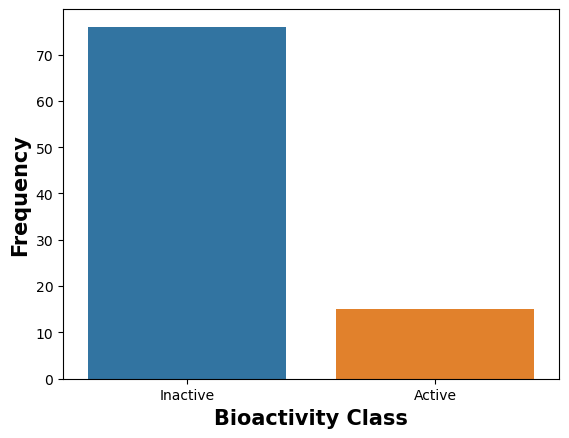

<Figure size 640x480 with 0 Axes>

In [25]:
sns.countplot(df2['bioactivity_class'], label='Bioactivity Class')

plt.xlabel('Bioactivity Class', fontsize=15, fontweight='bold')

plt.ylabel('Frequency', fontsize=15, fontweight='bold')

plt.show()

plt.savefig('Count plot of Bioactivity_class.pdf')

### Next we plot a scattered graph of the MW and LogP

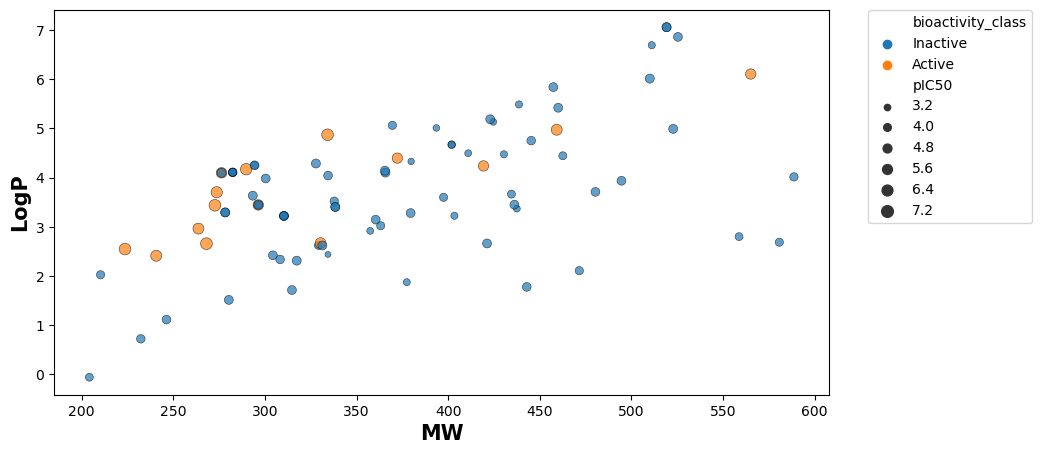

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(10, 5))

sns.scatterplot(x=df2['MW'], y=df2['LogP'], hue=df2['bioactivity_class'], alpha=0.7, size=df2['pIC50'], edgecolor='black')

plt.xlabel('MW', fontsize=15, fontweight='bold')

plt.ylabel('LogP', fontsize=15, fontweight='bold')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.show()

plt.savefig('A scatter plot of MW vs LogP.pdf')

#### BOXPLOT OF PIC50

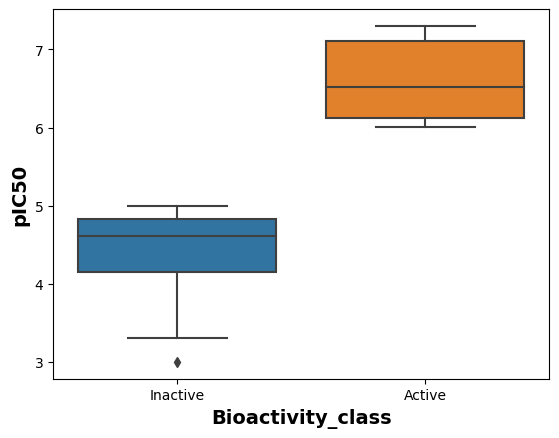

In [27]:
sns.boxplot(data=df2, x='bioactivity_class', y='pIC50')

plt.xlabel('Bioactivity_class', fontsize=14, fontweight='bold')

plt.ylabel('pIC50', fontsize=14, fontweight='bold')

plt.show()

In [28]:
df2['pIC50'].describe()

count    91.000000
mean      4.793064
std       0.953275
min       3.000000
25%       4.221849
50%       4.744727
75%       4.945042
max       7.301030
Name: pIC50, dtype: float64

#### Statistical analysis | Mann-Whitney U test

In [29]:
def mannwhitney (descriptor, verbose=False):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu
    
    # seed the random number generator
    
    seed(1)
    
    # Active and Inactives
    
    selection = [descriptor, 'bioactivity_class']
    
    df = df2[selection]
    active = df[df['bioactivity_class'] == 'Active']
    active = active[descriptor]
    
    selection = [descriptor, 'bioactivity_class']
    
    df = df2[selection]
    inactive = df[df['bioactivity_class'] == 'Inactive']
    inactive = inactive[descriptor]
    
    #compare samples
    
    stat, p = mannwhitneyu(active, inactive)
    #print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # Interprete
    alpha = 0.05
    if p > alpha:
        interprete = 'Same distribution (fail to reject null hypothesis(H0))'
    else:
        interpretation = 'Different distribution (reject H0)'
        
    results = pd.DataFrame({'Descriptors':descriptor, 'Statistics': stat, 'p':p, 'alpha':alpha,
                           'Interpretation':interpretation}, index=[0])
    
    filename = 'mannwhitneyu' + descriptor + '.csv'
    results.to_csv(filename)
    
    
    return results

In [30]:
mannwhitney('pIC50')

,Descriptors,Statistics,p,alpha,Interpretation
0,pIC50,1140.0,1.105265e-09,0.05,Different distribution (reject H0)


In [31]:
mannwhitney('MW')

,Descriptors,Statistics,p,alpha,Interpretation
0,MW,346.5,0.017047,0.05,Different distribution (reject H0)


#### Boxplot of MW

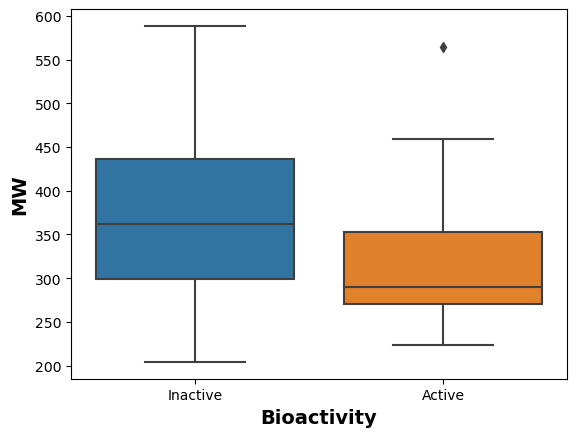

In [32]:
sns.boxplot(data=df2, x='bioactivity_class', y='MW')

plt.xlabel('Bioactivity', fontsize=14, fontweight='bold')

plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.show()

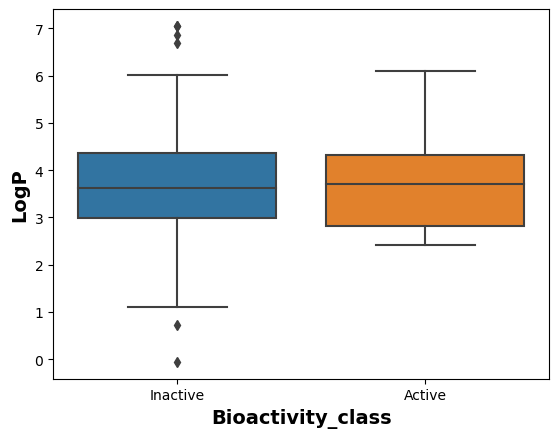

In [34]:
sns.boxplot(data=df2, x='bioactivity_class', y='LogP')

plt.xlabel('Bioactivity_class', fontsize=14, fontweight='bold')

plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.show()

In [36]:
mannwhitney('NumHDonors')

,Descriptors,Statistics,p,alpha,Interpretation
0,NumHDonors,279.0,0.000818,0.05,Different distribution (reject H0)


In [ ]:
bsns.boxplot(data=df2, x='bioactivity_class', y='NumHDonors')

plt.xlabel('Bioactivity_class', fontsize=14, fontweight='bold')

plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.show()

### INTERPRETATION OF STATISTICAL RESULTS

<br>

#### pIC50 Values



We observe from the pIC50 values that the <b>active compounds </b> and the <b>inactive compounds</b> displayed a statistically significant difference. Recall that we said compounds with <b>IC50 < $1,000nM$ = Active</b> whereas compounds with <b> IC50 > $10,000nM$ = Inactive</b>. which corresponds to <b>pIC50 > 6 = active</b> while <b>pIC50 < 5 = Inactive</b>. 
    
#### Lipinski Descriptors.
    
We notice from the active bioactivity_class, a compound with molecular_id <b>CHEMBL212454</b> failed two of the Lipinski rule of 5 test, We can see that the molecular mass of this compound is 565.041 which exceeds the <b>500 dalton</b> threshold. Also its <b>LogP value = 6.1</b> which exceed the LogP value threshold (5) of the Lipinski complaince test.
    
<br>
    
Of all the 4 Lipinski descriptors, only the the <b> LogP </b> exhibited no difference between the <b> actives</b> and <b>inactives</b>, while the other 3 descriptors show significant statistical difference between these two bioactive classes.

In [37]:
df2.to_csv('Corona_pIC50.csv', index=False)